In [1]:
# load package
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.formula.api import ols
from scipy.stats import shapiro
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification  
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

In [2]:
# load the dataframe, the data is pre-processed in R. For consistency, save it via R and then python reads it directly 
df = pd.read_csv("new_df.csv")
del df['ah3ffood']
# select the colounm I need
#features
features = df.iloc[:,3:]
#SAMHI the depedent variable
label_re = df.iloc[:,[1]]
label4_sam = pd.qcut(df['samhi_dec.2019'], q=4, labels=False)
# create folders to save the result
if not os.path.exists('result'):
    os.mkdir('result')

if not os.path.exists('result/sam'):
    os.mkdir('result/sam')

In [3]:
df.describe().T

count       mean        std       min        25%  \
samhi_index.2019  31810.0   0.707901   1.032556 -1.992091  -0.028375   
samhi_dec.2019    31810.0   5.526250   2.868866  1.000000   3.000000   
ah3gp             31810.0   4.642993   4.923733  0.000000   1.806625   
ah3dent           31810.0   4.846448   5.833241  0.000000   1.727025   
ah3phar           31810.0   3.944616   5.078093  0.000000   1.503750   
ah3hosp           31810.0   4.299761   4.996069  0.000000   1.568825   
ah3blue           31810.0   5.122887   3.597743  0.000000   2.449250   
ah3gpas           31810.0   0.431944   0.116358  0.000000   0.366161   
ah3gamb           31810.0   6.506023   8.549769  0.000000   1.899887   
ah3leis           31810.0   8.442498   9.676063  0.000000   2.782425   
ah3pubs           31810.0   4.496460   5.807297  0.000000   1.512500   
ah3tob            31810.0   9.139581  10.060671  0.000000   3.024500   
ah3no2            31810.0  14.455900   6.175400  2.939252   9.907898   
ah3so2            31810.0   1.500107   0.575749  0.277085   1.059027   
ah3pm10           31810.0  14.680013   2.508360  6.152995  12.980355   

                        50%        75%         max  
samhi_index.2019   0.576247   1.310505    7.568253  
samhi_dec.2019     6.000000   8.000000   10.000000  
ah3gp              3.013825   5.209763   50.527950  
ah3dent            2.929825   5.143487   94.746800  
ah3phar            2.375950   3.880713   64.165950  
ah3hosp            2.615500   4.579500   53.911600  
ah3blue            4.315497   6.891400   34.611100  
ah3gpas            0.433049   0.496857    0.816698  
ah3gamb            3.337500   6.602400  167.944400  
ah3leis            5.059450   9.668375  171.499400  
ah3pubs            2.659900   4.716337   94.231050  
ah3tob             5.446375  10.921275  167.923400  
ah3no2            13.565010  17.732937   44.202850  
ah3so2             1.425213   1.865038    6.738594  
ah3pm10           14.727075  16.333750   21.825480

In [4]:
label_re

samhi_index.2019
0             -1.183468
1             -1.189840
2             -0.580351
3             -0.897460
4             -1.237533
...                 ...
31805         -0.312738
31806          3.125373
31807          3.046193
31808          3.520225
31809          2.357979

[31810 rows x 1 columns]

In [5]:
data = df.iloc[:,3:]

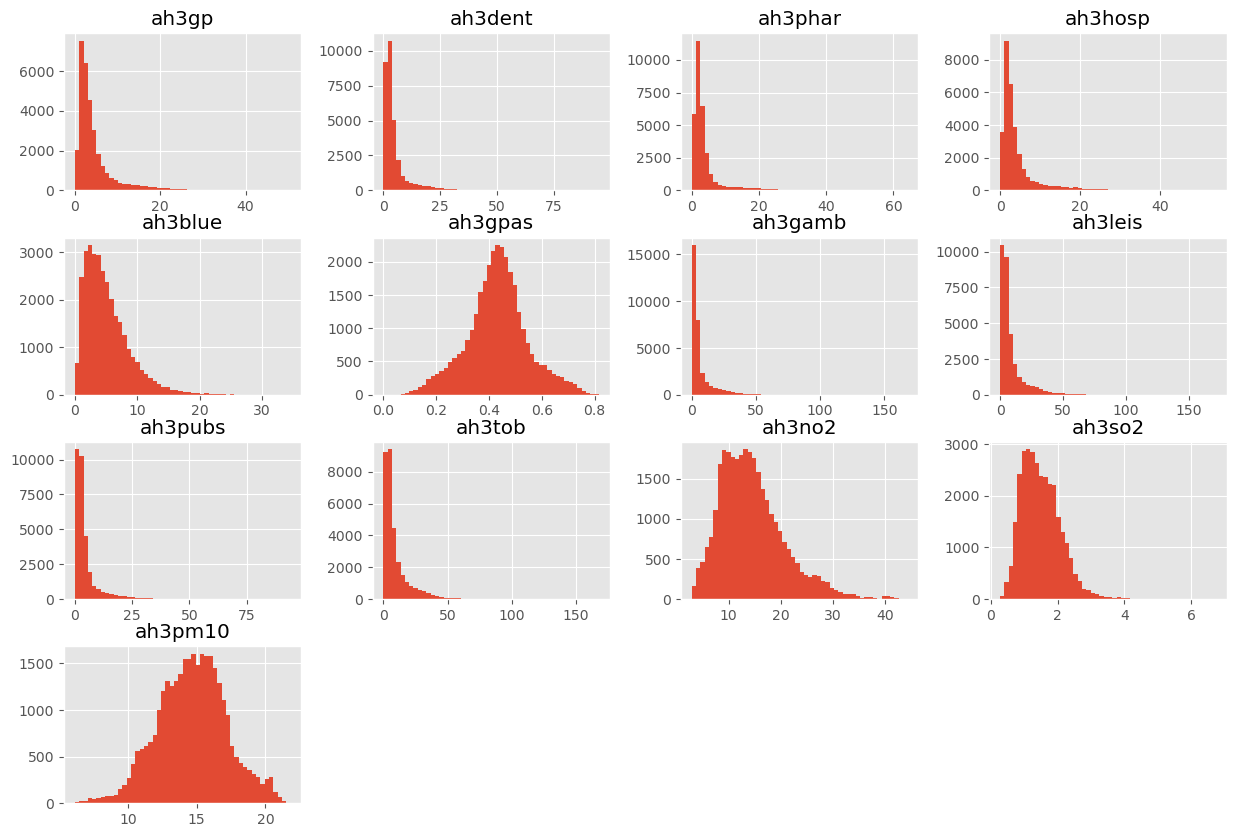

In [6]:
# 查看各项分布
data.hist(bins=50, figsize=(15,10))
plt.show()

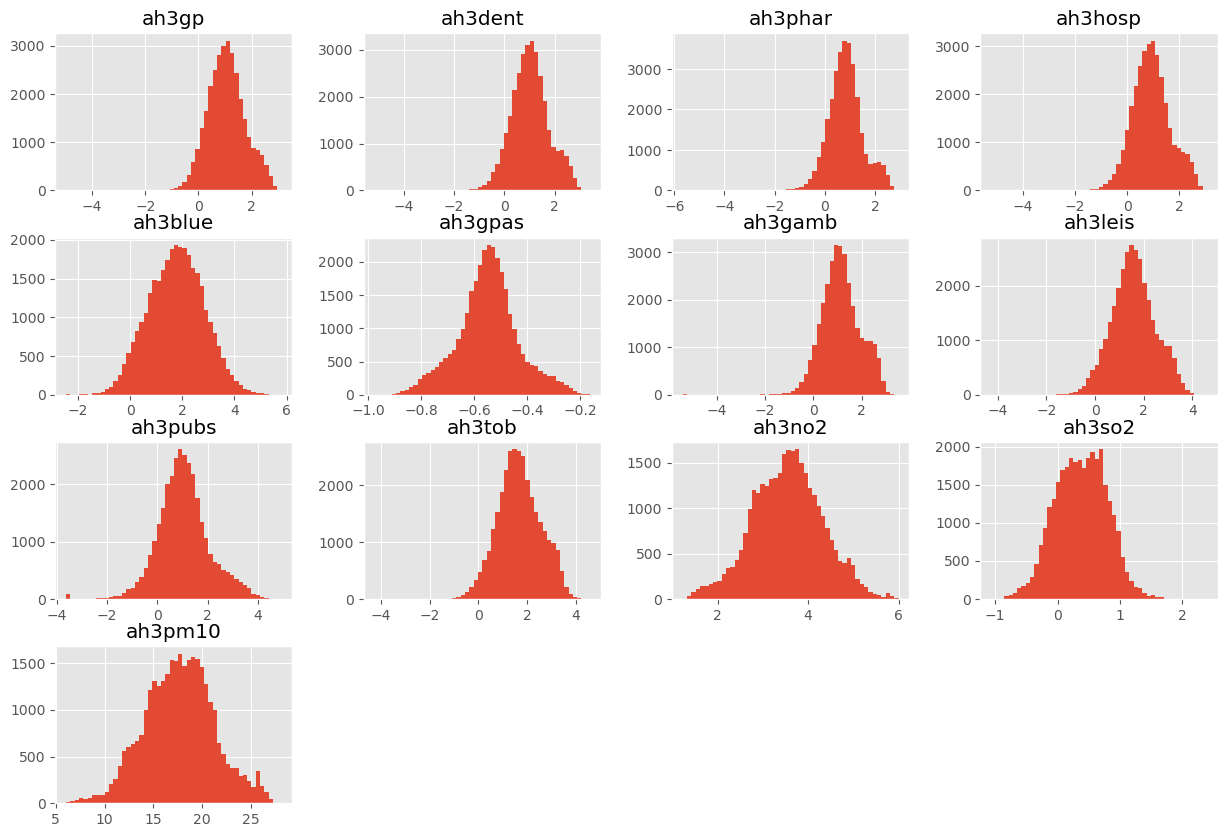

In [7]:
# BOX-COX transform, and show the processed data distribution
data_boxcox = pd.DataFrame()
for column in data.columns:
    transformed_data, _ = stats.boxcox(data[column]+0.02)
    data_boxcox[column] = transformed_data

data_boxcox.hist(bins=50, figsize=(15,10))

plt.show()

# ONE-way ANOVA

In [8]:
# regression
data_re = data_boxcox
data_re['samhi_dec']=label_re
# Get the column name of the variable
X_name = data.columns[:]
# ANOVA formula
formula = 'samhi_dec~ ' + '+'.join(X_name)
model = ols(formula, data=data_re).fit()
table = sm.stats.anova_lm(model)
table = table.round(5)
# save the result
table.to_csv('One-way ANOVA.csv')
print(table)

               df       sum_sq     mean_sq           F  PR(>F)
ah3gp         1.0     69.09071    69.09071    93.73911     0.0
ah3dent       1.0     53.84681    53.84681    73.05688     0.0
ah3phar       1.0    272.90836   272.90836   370.26958     0.0
ah3hosp       1.0   1382.78799  1382.78799  1876.10351     0.0
ah3blue       1.0     20.00683    20.00683    27.14435     0.0
ah3gpas       1.0    239.92460   239.92460   325.51873     0.0
ah3gamb       1.0     62.63847    62.63847    84.98501     0.0
ah3leis       1.0    695.67152   695.67152   943.85531     0.0
ah3pubs       1.0     46.19559    46.19559    62.67607     0.0
ah3tob        1.0    390.67746   390.67746   530.05331     0.0
ah3no2        1.0   2950.43594  2950.43594  4003.01656     0.0
ah3so2        1.0   2320.93805  2320.93805  3148.94261     0.0
ah3pm10       1.0   1973.37718  1973.37718  2677.38792     0.0
Residual  31796.0  23435.34176     0.73705         NaN     NaN


#  Stepwise-regression

In [9]:
# Define the Bidirectional Regression
def two_select(train_data, test_data, target):
    """
    Bidirectional Regression
    :param data
    :param target
    :return:
    """
    variate = list(set(train_data.columns))
    variate.remove(target)
    selected = []  # Save selected variables
    selected_h = []  # Store deleted variables
    # Initialization
    # Initialization coefficient of determination R ^ 2, the closer to 1, the better
    cur_score_f, best_score_f = 0.0, 0.0
    cur_score_h, best_score_h = 0.0, 0.0
    # Loop to delete variables until all variables are selected
    # Bidirectional selection - two steps forward and then one step backward
    while variate:
        variate_r2_f = []
        variate_r2_h = []
        # Find local optimum
        # two steps forward
        for i in range(2):
            for var in variate:
                selected.append(var)
                if len(selected) == 1:
                    model = Lasso().fit(train_data[selected[0]].values.reshape(-1, 1), train_data[target])
                    y_pred = model.predict(test_data[selected[0]].values.reshape(-1, 1))
                    R2 = r2_score(test_data[target], y_pred)
                    variate_r2_f.append((R2, var))
                    selected.remove(var)
                else:
                    model = Lasso().fit(train_data[selected], train_data[target])
                    y_pred = model.predict(test_data[selected])
                    R2 = r2_score(test_data[target], y_pred)
                    variate_r2_f.append((R2, var))
                    selected.remove(var)
            variate_r2_f.sort(reverse=False)  # Descending sort r2, default ascending order
            best_score_f, best_var_f = variate_r2_f.pop()  
            if cur_score_f < best_score_f:  # Compare the results, if it is better, do not remove it, otherwise remove it.
                selected.append(best_var_f)
                cur_score_f = best_score_f
                print("R2_f={},continue!".format(cur_score_f))
            else:
                variate.remove(best_var_f)
                break
        # one step backward
        for var in variate:
            variate.remove(var)
            if len(variate) == 1:
                model = Lasso().fit(train_data[variate[0]].values.reshape(-1, 1), train_data[target])
                y_pred = model.predict(test_data[variate[0]].values.reshape(-1, 1))
                R2 = r2_score(test_data[target], y_pred)
                variate_r2_h.append((R2, var))
                variate.append(var)
            else:
                model = Lasso().fit(train_data[variate], train_data[target])
                y_pred = model.predict(test_data[variate])
                R2 = r2_score(test_data[target], y_pred)
                variate_r2_h.append((R2, var))
                variate.append(var)
        variate_r2_h.sort(reverse=False)  
        best_score_h, best_var_h = variate_r2_h.pop()  
        if cur_score_h < best_score_h:  # better result after remove it
            variate.remove(best_var_h)
            selected_h.append(best_var_h)
            cur_score_h = best_score_h
            print("R2_h={},continue!".format(cur_score_h))
        else:
            print('for selection over!')
            selected = [var for var in set(train_data.columns) if var not in selected_h]
            selected_features = [str(i) for i in selected]
            print(selected_features)
            break
    return selected_features

In [10]:
data_OLS = data_boxcox
del data_OLS['samhi_dec']
data_OLS['sam']= label_re

In [11]:
# Define features and tags  
X = data_OLS.drop(['sam'], axis=1)  
y = data_OLS['sam'] 
features = data_OLS.columns
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train_data = pd.DataFrame(x_train, columns=features)
train_data["sam"] = y_train
test_data = pd.DataFrame(x_test, columns=features)
test_data["sam"] = y_test
selected_features = two_select(train_data,test_data, 'sam')
# train the model
X_select = data_OLS[selected_features]
del X_select['sam']
X_final = sm.add_constant(X_select)
model_final = sm.OLS(y, X_final)
result_final = model_final.fit(disp=False)
result = result_final.summary()
# Output regression model result table
print(result)
# save 
with open('result/sam/Bidirectional Regression.txt', 'w') as f:       
    f.write(str(result))
# save  
with open('result/sam/Bidirectional Regression2.txt', 'w') as f:  
    f.write(str(result_final.summary2()))

R2_f=0.09227610163197753,continue!
R2_h=0.09227610163197753,continue!
for selection over!
['ah3hosp', 'ah3gp', 'ah3tob', 'ah3no2', 'ah3so2', 'ah3pm10', 'ah3gamb', 'ah3phar', 'sam', 'ah3blue', 'ah3dent', 'ah3leis', 'ah3gpas']
                            OLS Regression Results                            
Dep. Variable:                    sam   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     1164.
Date:                Sun, 20 Aug 2023   Prob (F-statistic):               0.00
Time:                        19:11:47   Log-Likelihood:                -40364.
No. Observations:               31810   AIC:                         8.075e+04
Df Residuals:                   31797   BIC:                         8.086e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                           